In [1]:
import os
import cv2
import json
import numpy as np
import pandas as pd
import torch
from torch import nn
from copy import deepcopy
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, Subset
from torchvision import transforms, datasets, models
from torchvision.models import resnet50, densenet121, inception_v3
from torchsummary import summary
from collections import OrderedDict
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
from skimage.io import imread
from skimage.transform import resize
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import seaborn as sns
import wandb
import torch.nn.functional as F
from sklearn.model_selection import StratifiedKFold

/home/ubuntu/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/ubuntu/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/home/ubuntu/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
BATCH_SIZE = 4

In [3]:
class AugmentedDataset(Dataset):
    def __init__(self, root_dir, transform=None, train=False):
        self.dataset = datasets.ImageFolder(root_dir)
        self.transform = transform
        self.train = train
        self.classes = self.dataset.classes
        self.class_to_idx = self.dataset.class_to_idx
        
        self.augment_classes = ['None', 'Many']
        self.augment_indices = [self.class_to_idx[cls] for cls in self.augment_classes if cls in self.class_to_idx]
        
        # Count samples per class
        self.class_counts = [0] * len(self.classes)
        for _, label in self.dataset.samples:
            self.class_counts[label] += 1
        
        # Calculate class weights once
        total_samples = sum(self.class_counts)
        self.class_weights = [total_samples / (len(self.class_counts) * count) for count in self.class_counts]
        
        if self.train:
            self.train_augs = A.Compose([
                A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),  # Reduced limits
                A.GaussNoise(var_limit=(5.0, 20.0), p=0.3),  # Reduced upper var_limit
                A.ShiftScaleRotate(shift_limit=0.03, scale_limit=0.1, rotate_limit=10, p=0.5),])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        
        if self.train and label in self.augment_indices:
            img_np = np.array(img)
            augmented = self.train_augs(image=img_np)
            img_np = augmented['image']
            img = Image.fromarray(img_np)
        
        if self.transform:
            img = self.transform(img)
        
        return img, label

    def get_sample_weights(self):
        return [self.class_weights[label] for _, label in self.dataset.samples]

In [4]:
def create_weighted_sampler(dataset, indices):
    sample_weights = dataset.get_sample_weights()
    subset_weights = [sample_weights[i] for i in indices]
    return WeightedRandomSampler(subset_weights, len(subset_weights), replacement=True)

# Define your transformations
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

# Create full datasets
full_dataset = AugmentedDataset('data', transform=transform)
print(len(full_dataset))
print(full_dataset.class_counts)
print(sum(full_dataset.class_counts))
dummy_loader = DataLoader(full_dataset, batch_size=1, shuffle=True)

8724
[6232, 256, 2236]
8724


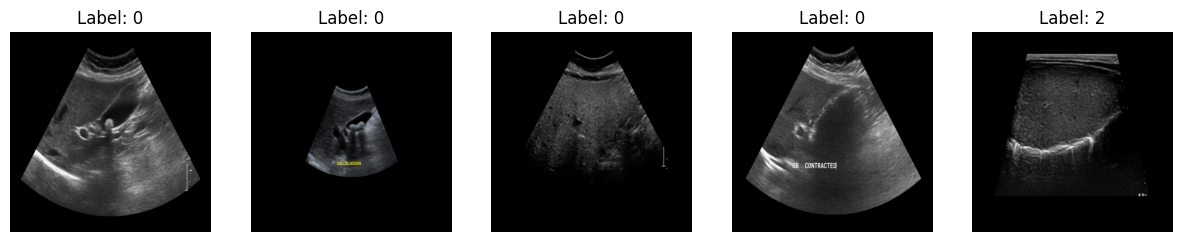

In [5]:
# Function to get images of a specific label
def get_images_by_label(dataloader, num_images=1, label=None):
    images = []
    labels = []
    if label is None:
        # Get random images not considering the label
        for batch_images, batch_labels in dataloader:
            for img, lbl in zip(batch_images, batch_labels):
                images.append(img)
                labels.append(lbl)
                if len(images) >= num_images:
                    return images, labels
    for batch_images, batch_labels in dataloader:
        for img, lbl in zip(batch_images, batch_labels):
            if lbl == label:
                images.append(img)
                labels.append(lbl)
                if len(images) >= num_images:
                    return images, labels
    return images, labels

# Example usage: Get 5 images of label 0
label_to_display = 2
num_images_to_display = 5
images, labels = get_images_by_label(dummy_loader, num_images_to_display, label=None)

# Display the images
fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 5))
for i, (img, lbl) in enumerate(zip(images, labels)):
    axes[i].imshow(img.permute(1, 2, 0))
    axes[i].set_title(f'Label: {lbl}')
    axes[i].axis('off')
plt.show()

In [6]:
num_class = len(dummy_loader.dataset.classes)
print(num_class)
print(dummy_loader.dataset.classes)

3
['Few', 'Many', 'None']


In [7]:
class_weights = torch.tensor(full_dataset.class_weights, dtype=torch.float)
print(class_weights)
print(full_dataset.classes)

tensor([ 0.4666, 11.3594,  1.3005])
['Few', 'Many', 'None']


In [8]:
for batch in dummy_loader:
    print(batch)
    break

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]]), tensor([0])]


In [9]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score


def calculate_metrics(y_true, y_pred, y_prob, train=False):

    if train:
        auc = roc_auc_score(y_true, y_prob, multi_class='ovr', average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')
        return auc, f1
    
    cm = confusion_matrix(y_true, y_pred)

    # Calculate metrics for each class
    metrics = []
    sensitivities = []
    specificities = []
    
    for i in range(len(cm)):
        TP = cm[i, i]
        FP = cm[:, i].sum() - TP
        FN = cm[i, :].sum() - TP
        TN = cm.sum() - TP - FP - FN
        
        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        
        sensitivities.append(sensitivity)
        specificities.append(specificity)
        
        metrics.append({
            'sensitivity': sensitivity,
            'specificity': specificity
        })
    
    # Calculate overall accuracy
    accuracy = accuracy_score(y_true, y_pred)
    
    # Calculate ROC-AUC and F1 score for validation set
    auc = roc_auc_score(y_true, y_prob, multi_class='ovr', average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    # Calculate averaged sensitivity and specificity
    avg_sensitivity = sum(sensitivities) / len(sensitivities) if sensitivities else 0
    avg_specificity = sum(specificities) / len(specificities) if specificities else 0
    
    return accuracy, metrics, auc, f1, cm, avg_sensitivity, avg_specificity

def plot_confusion_matrix(cm, class_names, epoch_num=0, model_name='model', fold_num=0):
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(f'figures/confusion_matrix_{model_name}_epoch_{epoch_num}_fold{fold_num}.png')
    plt.close()

def custom_log(metrics, model_name, log_dir='logs'):
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    log_file = f'{log_dir}/{model_name}_metrics_log.json'
    with open(log_file, 'a') as f:
        f.write(json.dumps(metrics) + '\n')

In [10]:
import torch
import torch.nn.functional as F
import numpy as np
import wandb

def train_model(model, criterion, optimizer, train_loader, val_loader, class_names, num_epochs=30, device='cuda', model_name='model', fold=0):
    wandb.init(project="Hepatocyte Ballooning Detection", name=f"RadImageNet {model_name} Fold {fold+1}")
    wandb.watch(model, criterion, log='all')

    print(f'Training {model_name} for {num_epochs} epochs on Fold {fold+1}')
    max_f1 = 0
    best_metrics = {}
    
    for e in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_preds, train_labels, train_probs = [], [], []


        for i_batch, batch in enumerate(train_loader):
            data, labels = batch[0].to(device, dtype=torch.float), batch[1].to(device)
            
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            probs = F.softmax(outputs, dim=1)  # Get probabilities

            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
            train_probs.extend(probs.detach().cpu().numpy())  # Store probabilities

        # Calculate metrics
        train_auc, train_f1 = calculate_metrics(train_labels, train_preds, train_probs, train=True)


        # Validation phase
        model.eval()
        val_loss = 0.0
        val_preds, val_labels, val_probs = [], [], []

        with torch.no_grad():
            for i_batch, batch in enumerate(val_loader):
                data, labels = batch[0].to(device, dtype=torch.float), batch[1].to(device)
                
                outputs = model(data)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * data.size(0)

                probs = F.softmax(outputs, dim=1)
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
                val_probs.extend(probs.cpu().numpy())

        # Calculate metrics
        val_accuracy, val_class_metrics, val_auc, val_f1, val_cm, avg_sensitivity, avg_specificity = calculate_metrics(val_labels, val_preds, val_probs)

        print(f'Epoch {e+1}')
        val_loss /= len(val_loader.dataset)
        train_loss /= len(train_loader.dataset)
        print(f'Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
        print(f'Validation Accuracy: {val_accuracy:.4f}')
        print(f'Validation AUC: {val_auc:.4f}')
        print(f'Macro-averaged F1 Score: {val_f1:.4f}')
        print(f'Averaged Sensitivity: {avg_sensitivity:.4f}, Averaged Specificity: {avg_specificity:.4f}')
        for i, metrics in enumerate(val_class_metrics):
            print(f'Class {class_names[i]} - Sensitivity: {metrics["sensitivity"]:.4f}, Specificity: {metrics["specificity"]:.4f}')

        # Log metrics to wandb and custom logger
        metrics = {
            'fold': fold + 1,
            'epoch': e + 1,
            'train_loss': train_loss,
            'train_auc': train_auc,
            'train_f1': train_f1,
            'val_loss': val_loss,
            'val_accuracy': val_accuracy,
            'val_auc': val_auc,
            'val_f1': val_f1,
            'avg_sensitivity': avg_sensitivity,
            'avg_specificity': avg_specificity,
            **{f'class_{class_names[i]}_sensitivity': metrics["sensitivity"] for i, metrics in enumerate(val_class_metrics)},
            **{f'class_{class_names[i]}_specificity': metrics["specificity"] for i, metrics in enumerate(val_class_metrics)},
            **{f'class_{class_names[i]}_f1': 2 * metrics["sensitivity"] * metrics["specificity"] / (metrics["sensitivity"] + metrics["specificity"]) for i, metrics in enumerate(val_class_metrics)}
        }

        # Log to wandb
        wandb.log(metrics)

        # Log to custom logger
        custom_log(metrics, model_name)

        # Save the last model and delete one before it to chekpoint directory
        torch.save(model.state_dict(), f'checkpoints/last_{model_name}_epoch_{e+1}_fold_{fold+1}.pth')
        if e > 0:
            os.remove(f'checkpoints/last_{model_name}_epoch_{e}_fold_{fold+1}.pth')
        
        # Save the best model
        if max_f1 < val_f1:
            print(f'Macro F1 Increased({max_f1:.6f}--->{val_f1:.6f}) \t Saving The Model')
            max_f1 = val_f1
            best_metrics = deepcopy(metrics)
            torch.save(model.state_dict(), f'checkpoints/best/best_{model_name}_epoch_{e+1}_fold_{fold+1}.pth')
            
            # Plot confusion matrix for the best model
            plot_confusion_matrix(val_cm, class_names, e+1, model_name, fold+1)

    return model, best_metrics

In [11]:
models = os.listdir('models')
print(models)
model_name = models[2] # InceptionV3

['DenseNet121.pt', 'ResNet50.pt', 'InceptionV3.pt']


In [12]:
# Define the path to the data
data_path = 'data'

# List the folders in the data path
folders = [f for f in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, f))]

# Initialize a dictionary to store the count of images in each folder
image_counts = {}

# Iterate through each folder and count the number of image files
for folder in folders:
    folder_path = os.path.join(data_path, folder)
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
    image_counts[folder] = len(image_files)

# Display the results
for folder, count in image_counts.items():
    print(f'Folder: {folder}, Number of images: {count}')

Folder: Few, Number of images: 6232
Folder: None, Number of images: 2236
Folder: Many, Number of images: 256


In [13]:
# Make all the needed directories
os.makedirs('checkpoints', exist_ok=True)
os.makedirs('checkpoints/best', exist_ok=True)
os.makedirs('logs', exist_ok=True)
os.makedirs('logs/best', exist_ok=True)
os.makedirs('figures', exist_ok=True)

In [14]:
from torchvision.models import efficientnet_b0

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
best_metrics_lst = []

base_model = efficientnet_b0(weights=None)
base_model.classifier[1] = nn.Linear(base_model.classifier[1].in_features, num_class)
model_name = 'EfficientNetB0'

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# start from 2nd fold
for fold, (train_idx, val_idx) in enumerate(skf.split(full_dataset, full_dataset.dataset.targets)):
	print(f"Fold {fold + 1}")
	
	# Create training and validation subsets
	train_subset = Subset(full_dataset, train_idx)
	val_subset = Subset(full_dataset, val_idx)
	
	sampler = create_weighted_sampler(full_dataset, train_idx)

	# Create DataLoaders
	train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, sampler=sampler)
	val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)
	
	# Create a deep copy of the model for this fold
	model = deepcopy(base_model)
	model = model.to(device)

	# Define loss function and optimizer
	criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
	optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

	# Train the model
	model, best_metrics = train_model(model, criterion, optimizer, train_loader, val_loader, full_dataset.dataset.classes, num_epochs=30, device=device, model_name=model_name, fold=fold)
	best_metrics_lst.append(best_metrics)
	custom_log(best_metrics, model_name + '_best', log_dir='logs/best')
	print(f"Best Validation Metrics of Fold {fold+1}:")
	print(f"Accuracy: {best_metrics['val_accuracy']:.4f}")
	print(f"AUC: {best_metrics['val_auc']:.4f}")
	print(f'Macro-averaged F1 Score: {best_metrics["val_f1"]:.4f}')
	print(f'Averaged Sensitivity: {best_metrics["avg_sensitivity"]:.4f}, Averaged Specificity: {best_metrics["avg_specificity"]:.4f}')
	
	wandb.finish()

Fold 1


wandb: Currently logged in as: samwellwatwat. Use `wandb login --relogin` to force relogin


Training EfficientNetB0 for 30 epochs on Fold 1
Epoch 1
Training Loss: 0.1938, Validation Loss: 1.4225
Validation Accuracy: 0.3459
Validation AUC: 0.6040
Macro-averaged F1 Score: 0.4184
Averaged Sensitivity: 0.4742, Averaged Specificity: 0.7092
Class Few - Sensitivity: 0.4359, Specificity: 0.7269
Class Many - Sensitivity: 0.9600, Specificity: 0.4269
Class None - Sensitivity: 0.0268, Specificity: 0.9738
Macro F1 Increased(0.000000--->0.418394) 	 Saving The Model
Epoch 2
Training Loss: 0.1796, Validation Loss: 1.8191
Validation Accuracy: 0.0619
Validation AUC: 0.6006
Macro-averaged F1 Score: 0.0369
Averaged Sensitivity: 0.3765, Averaged Specificity: 0.6571
Class Few - Sensitivity: 0.0000, Specificity: 1.0000
Class Many - Sensitivity: 1.0000, Specificity: 0.2394
Class None - Sensitivity: 0.1295, Specificity: 0.7319
Epoch 3
Training Loss: 0.1661, Validation Loss: 1.3643
Validation Accuracy: 0.1649
Validation AUC: 0.6223
Macro-averaged F1 Score: 0.0834
Averaged Sensitivity: 0.4749, Averaged

avg_sensitivity,▄▁▄▄▄▆▅▆▄▅▇▆█▇▇▅█▇▆▇▆▇▄█▆▇▄▇▅█
avg_specificity,▄▁▁▁▁▄▃▄▂▃▅▃▇▅▆▄▆▇▅█▆▅▃█▆▇▂█▄█
class_Few_f1,▇▁▁▂▂▅▃▅▃▃▅▄█▆▆▄▇▇▆█▆▆▂█▆▇▁▇▄█
class_Few_sensitivity,▆▁▁▂▁▄▂▄▂▂▄▃▇▄▅▃▆▇▄█▅▅▂█▅▇▁▆▃▇
class_Few_specificity,▁███▇▅▇▆▇▇▆▅▁▅▄▇▂▂▆▂▄▅▇▂▅▃█▄▇▂
class_Many_f1,▄▁▇▇▇▇▇▇▇▇▇█▇█▇▆█▇▆▆▅█▅▇▆▇▅▆▅▆
class_Many_sensitivity,▇█▆▇▇▇▆▅▄▅▄▆▄▅▄▃▅▃▂▂▁▅▁▃▂▄▁▂▁▂
class_Many_specificity,▃▁▅▆▅▅▅▇▇▆▇▆▇▇▇▇▇▇███▇███▇█▇██
class_None_f1,▁▃▅▅▅▆▆▆▅▆▆▆█▇▇▅▇█▆█▇▇▃█▇█▂█▅█
class_None_sensitivity,▁▂▅▅▄▄▅▆▆▆▆▅▅▆▆▇▅▆▇▆▆▆█▅▇▅█▆▇▆
class_None_specificity,█▆▃▃▄▅▄▄▃▃▃▃▅▄▄▃▅▅▃▅▄▄▁▆▄▅▁▅▂▅


Fold 2


Training EfficientNetB0 for 30 epochs on Fold 2
Epoch 1
Training Loss: 0.1917, Validation Loss: 1.5659
Validation Accuracy: 0.0550
Validation AUC: 0.6030
Macro-averaged F1 Score: 0.0522
Averaged Sensitivity: 0.3456, Averaged Specificity: 0.6729
Class Few - Sensitivity: 0.0369, Specificity: 0.9880
Class Many - Sensitivity: 1.0000, Specificity: 0.0307
Class None - Sensitivity: 0.0000, Specificity: 1.0000
Macro F1 Increased(0.000000--->0.052226) 	 Saving The Model
Epoch 2
Training Loss: 0.1624, Validation Loss: 1.9038
Validation Accuracy: 0.0710
Validation AUC: 0.5787
Macro-averaged F1 Score: 0.0467
Averaged Sensitivity: 0.3884, Averaged Specificity: 0.6614
Class Few - Sensitivity: 0.0000, Specificity: 1.0000
Class Many - Sensitivity: 1.0000, Specificity: 0.2370
Class None - Sensitivity: 0.1652, Specificity: 0.7473
Epoch 3
Training Loss: 0.1563, Validation Loss: 1.6893
Validation Accuracy: 0.1329
Validation AUC: 0.5914
Macro-averaged F1 Score: 0.0773
Averaged Sensitivity: 0.4659, Averaged

avg_sensitivity,▁▂▄▃▅▄▆▆▆▅█▇▇▇▅▇▆▆▄▆▃▃▅▆▇▆▅▆▅▇
avg_specificity,▂▁▁▁▂▁▃▂▂▂▇▅▄▆▂▆▅▂▂▇▂▂▂▂▆▂▂▃▃█
class_Few_f1,▂▁▁▂▄▁▄▂▁▁█▆▄▇▁▇▇▁▁█▁▁▁▂▇▁▁▃▃█
class_Few_sensitivity,▁▁▁▁▂▁▂▂▁▁▆▄▃▅▁▅▄▁▁▇▁▁▁▂▄▁▁▂▂█
class_Few_specificity,███▇▇█▇███▄▆▇▅█▄▅██▂████▆████▁
class_Many_f1,▁▄▇▇▇▇████████▇▇▇█▆▅▄▅▇██▇▇▇▆▆
class_Many_sensitivity,███▇████▆▇▆▆▆▅▄▄▄▆▃▁▁▂▄▆▆▅▄▄▃▃
class_Many_specificity,▁▃▅▅▅▅▆▆▇▆▇█▇████▇█████▇▇█████
class_None_f1,▁▄▅▅▆▅▆▆▄▅█▇▆▇▃▇▇▃▃█▂▂▃▄█▂▃▄▃█
class_None_sensitivity,▁▂▄▄▄▄▅▆▇▆▅▆▇▆█▆▆▇█▅███▇▆████▅
class_None_specificity,█▆▄▄▄▃▄▃▂▂▆▄▃▅▁▅▄▂▁▆▁▁▁▂▅▁▁▂▂▇


Fold 3


Training EfficientNetB0 for 30 epochs on Fold 3
Epoch 1
Training Loss: 0.2027, Validation Loss: 1.7390
Validation Accuracy: 0.0538
Validation AUC: 0.5573
Macro-averaged F1 Score: 0.0482
Averaged Sensitivity: 0.3446, Averaged Specificity: 0.6731
Class Few - Sensitivity: 0.0337, Specificity: 0.9920
Class Many - Sensitivity: 1.0000, Specificity: 0.0272
Class None - Sensitivity: 0.0000, Specificity: 1.0000
Macro F1 Increased(0.000000--->0.048165) 	 Saving The Model
Epoch 2
Training Loss: 0.1907, Validation Loss: 1.7036
Validation Accuracy: 0.0435
Validation AUC: 0.5340
Macro-averaged F1 Score: 0.0230
Averaged Sensitivity: 0.3512, Averaged Specificity: 0.6647
Class Few - Sensitivity: 0.0000, Specificity: 1.0000
Class Many - Sensitivity: 1.0000, Specificity: 0.0803
Class None - Sensitivity: 0.0536, Specificity: 0.9137
Epoch 3
Training Loss: 0.1891, Validation Loss: 1.7813
Validation Accuracy: 0.0985
Validation AUC: 0.5794
Macro-averaged F1 Score: 0.0598
Averaged Sensitivity: 0.4000, Averaged

avg_sensitivity,▁▁▂▃▄▅▆▅▇▅█▄▆▇▇▅▇▃▆▇█▅▅█▄▆▇▆██
avg_specificity,▂▁▁▁▁▃▂▂▃▂▅▁▄▃▄▃▇▂▂▃▆▃▂▆▃▄▂▄█▆
class_Few_f1,▂▁▁▁▁▅▁▁▅▁▆▁▅▃▅▃▇▂▂▃▇▄▁▇▃▅▂▅█▇
class_Few_sensitivity,▁▁▁▁▁▄▁▁▄▁▅▁▄▃▄▂▇▁▁▂▆▃▁▆▃▄▂▄█▆
class_Few_specificity,█████▄██▄█▃█▄▆▄▇▁▇█▇▂▆█▃▇▄▇▅▁▁
class_Many_f1,▁▂▅▅▇▇▇██▇█▇▇█▇▇▇▅▇█▇▆▆▇▅▆█▆▆▇
class_Many_sensitivity,██▇███▇▆█▇▅▄▄▆▄▄▄▁▅▆▅▃▃▅▂▃▆▃▃▅
class_Many_specificity,▁▁▄▃▅▅▆▇▆▆█▇█▇████▇▇███▇██▇██▇
class_None_f1,▁▂▅▅▅▅▅▄▆▅▇▄▆▅▅▄█▃▄▆▇▄▃▇▄▆▄▆█▇
class_None_sensitivity,▁▁▃▃▄▄▆▇▅▆▆▇▇▇▇█▆█▇▇▆▇█▆▇▇▇▇▆▆
class_None_specificity,█▇▅▅▃▅▃▂▄▂▄▂▃▂▃▂▅▁▁▃▅▂▁▄▂▃▂▃▅▅


Fold 4


Training EfficientNetB0 for 30 epochs on Fold 4
Epoch 1
Training Loss: 0.1989, Validation Loss: 1.8077
Validation Accuracy: 0.0550
Validation AUC: 0.5651
Macro-averaged F1 Score: 0.0354
Averaged Sensitivity: 0.3661, Averaged Specificity: 0.6643
Class Few - Sensitivity: 0.0000, Specificity: 1.0000
Class Many - Sensitivity: 1.0000, Specificity: 0.1346
Class None - Sensitivity: 0.0982, Specificity: 0.8582
Macro F1 Increased(0.000000--->0.035375) 	 Saving The Model
Epoch 2
Training Loss: 0.1940, Validation Loss: 1.6021
Validation Accuracy: 0.2474
Validation AUC: 0.5732
Macro-averaged F1 Score: 0.3235
Averaged Sensitivity: 0.4683, Averaged Specificity: 0.7001
Class Few - Sensitivity: 0.2488, Specificity: 0.8920
Class Many - Sensitivity: 1.0000, Specificity: 0.4132
Class None - Sensitivity: 0.1562, Specificity: 0.7951
Macro F1 Increased(0.035375--->0.323454) 	 Saving The Model
Epoch 3
Training Loss: 0.1760, Validation Loss: 1.9331
Validation Accuracy: 0.0859
Validation AUC: 0.6018
Macro-aver

avg_sensitivity,▁▄▂▁▅▃▆▄▅▇▇▇▆▆▆▇▇▆█▆▆▆▅▆▆▇▆▅▆▆
avg_specificity,▂▄▁▁▆▁▆▂▂▇▅▃▃▅▄▆▆██▄▄▆▃▇▄▃▅▅▂▃
class_Few_f1,▁▆▁▁█▁█▂▁█▆▂▃▅▄▇▅██▃▄▇▂▇▃▂▄▅▁▂
class_Few_sensitivity,▁▅▁▁█▁█▂▁▇▅▁▂▄▃▇▄█▇▂▃▆▂▆▃▂▃▄▁▂
class_Few_specificity,█▅██▁█▁▇█▃▅█▇▅▇▂▆▃▄█▇▄█▅██▇▇██
class_Many_f1,▁▅▄▃▆▆▇▇▇▇▇█▇▇▇▇▇▆▇▇▇▆▆▅▇█▆▅▇▇
class_Many_sensitivity,████▇▆▇▇▇▇▇▇▇▆▅▃▆▂▅▅▅▃▂▁▄▇▃▁▇▅
class_Many_specificity,▁▃▃▂▄▅▆▅▆▆▇▇▆▇▇█▇█▇██████▇██▆▇
class_None_f1,▁▂▃▂▁▅▅▅▄▇▇▄▅▇▅▇▆██▂▄▆▁▇▄▃▄▅▅▃
class_None_sensitivity,▁▁▂▁▁▄▃▅▅▄▅▇▆▆▇▆▇▆▆█▇▇█▇█▇██▆▇
class_None_specificity,█▇▅▆█▃▇▃▂▆▄▂▃▄▃▄▃▅▅▁▂▃▁▄▂▂▂▂▃▁


Fold 5


Training EfficientNetB0 for 30 epochs on Fold 5
Epoch 1
Training Loss: 0.1945, Validation Loss: 1.4118
Validation Accuracy: 0.4415
Validation AUC: 0.6294
Macro-averaged F1 Score: 0.5034
Averaged Sensitivity: 0.5208, Averaged Specificity: 0.7212
Class Few - Sensitivity: 0.4703, Specificity: 0.7430
Class Many - Sensitivity: 0.7692, Specificity: 0.7612
Class None - Sensitivity: 0.3229, Specificity: 0.6595
Macro F1 Increased(0.000000--->0.503388) 	 Saving The Model
Epoch 2
Training Loss: 0.1741, Validation Loss: 1.5046
Validation Accuracy: 0.1376
Validation AUC: 0.5975
Macro-averaged F1 Score: 0.0678
Averaged Sensitivity: 0.4399, Averaged Specificity: 0.6489
Class Few - Sensitivity: 0.0000, Specificity: 1.0000
Class Many - Sensitivity: 0.8846, Specificity: 0.6525
Class None - Sensitivity: 0.4350, Specificity: 0.2943
Epoch 3
Training Loss: 0.1622, Validation Loss: 1.4802
Validation Accuracy: 0.1456
Validation AUC: 0.5958
Macro-averaged F1 Score: 0.0718
Averaged Sensitivity: 0.4503, Averaged

avg_sensitivity,▄▂▂▄▁▃▃▄▅▄▄▇▄▆▇▅▇▆▇▆▅█▇▇▆▆▇▇▇█
avg_specificity,▄▁▁▄▁▂▂▂▄▂▃▅▂▆▆▃▇▆▆▄▄▇▇▇▄▅▇█▇█
class_Few_f1,▇▁▁▆▁▁▁▁▄▁▂▅▁▇▆▃▇▆▇▄▃███▄▄▇█▇█
class_Few_sensitivity,▆▁▁▅▁▁▁▁▃▁▁▄▁▇▅▂▆▅▆▃▂█▇█▃▃▆▇▆▇
class_Few_specificity,▂██▄████▇██▅█▁▅█▄▆▄▇█▁▄▂█▇▅▄▅▄
class_Many_f1,▆▅▅▄▁▅▅▄▆▅▅█▆▆▇▆▆▆▇█▅▇▅▄▇▇▅▃▅▆
class_Many_sensitivity,▅▇▇▆▇▇▇█▇█▄▇▆▅▅▄▄▄▆▅▂▄▂▂▅▄▂▁▂▃
class_Many_specificity,▅▄▄▃▁▃▃▂▄▃▆▆▅▅▇▇▇▆▅▇█▇██▇▇████
class_None_f1,▃▁▂▃▁▃▃▄▅▃▁▆▃▅▆▁▇▆▇▂▁▇▇▇▃▃▇▇▇█
class_None_sensitivity,▂▃▃▁▁▄▄▄▄▄▇▆▆▃▆▇▆▇▄▇█▄▆▅▇█▇▇▇▇
class_None_specificity,▇▂▂▇▅▃▃▄▅▃▁▅▂█▅▁▆▅▇▂▁█▆▇▂▂▅▅▅▆


Fold 6


Training EfficientNetB0 for 30 epochs on Fold 6
Epoch 1
Training Loss: 0.1900, Validation Loss: 1.5984
Validation Accuracy: 0.0883
Validation AUC: 0.5976
Macro-averaged F1 Score: 0.0595
Averaged Sensitivity: 0.4067, Averaged Specificity: 0.6597
Class Few - Sensitivity: 0.0048, Specificity: 0.9960
Class Many - Sensitivity: 1.0000, Specificity: 0.3191
Class None - Sensitivity: 0.2152, Specificity: 0.6641
Macro F1 Increased(0.000000--->0.059511) 	 Saving The Model
Epoch 2
Training Loss: 0.1749, Validation Loss: 1.5124
Validation Accuracy: 0.1112
Validation AUC: 0.6155
Macro-averaged F1 Score: 0.0593
Averaged Sensitivity: 0.4395, Averaged Specificity: 0.6523
Class Few - Sensitivity: 0.0000, Specificity: 1.0000
Class Many - Sensitivity: 1.0000, Specificity: 0.5024
Class None - Sensitivity: 0.3184, Specificity: 0.4545
Epoch 3
Training Loss: 0.1692, Validation Loss: 1.8393
Validation Accuracy: 0.1078
Validation AUC: 0.6086
Macro-averaged F1 Score: 0.0596
Averaged Sensitivity: 0.4350, Averaged

avg_sensitivity,▁▂▂▃▃▆▆▇▆▅▇▆▅▇▇▇█▆▇▆▅▃▅█▆▄▇▇▅█
avg_specificity,▁▁▁▁▃▃▃▃▃▂▅▄▂▃▄▆▄▆▄▆▃▃▂▆▄▃▅█▄█
class_Few_f1,▁▁▁▁▅▄▃▄▂▂▆▅▁▃▃▆▅▇▅▇▃▃▁▆▄▃▅█▃█
class_Few_sensitivity,▁▁▁▁▄▃▂▃▁▁▄▃▁▂▂▅▄▆▄▆▂▂▁▅▃▂▄█▂█
class_Few_specificity,████▅▅▇▅██▄▆█▇▇▅▆▂▆▃███▆▇▇▆▁▇▂
class_Many_f1,▁▄▄▅▃▇▇██▇█▇▆█▇▇█▅█▄▆▃▆▇▆▅▇▅▅▅
class_Many_sensitivity,█████▇█▇▆▇▆▅▄▆▅▅▇▃▇▁▃▁▄▅▄▃▄▂▂▃
class_Many_specificity,▁▃▃▄▂▆▅▇▇▆▇▇▇▇██▇▇▆███▇▇▇▇████
class_None_f1,▃▃▃▄▂▅▅▅▂▄▆▅▁▄▃▆▅▇▆▆▂▁▁▆▅▃▄█▂█
class_None_sensitivity,▁▂▂▃▁▅▅▆▇▆▆▇▇▇▇▆▆▅▆▆███▇▇▇▇▅█▆
class_None_specificity,▇▄▅▄█▅▄▄▁▃▄▃▁▂▂▅▄▆▄▅▂▁▁▄▃▂▃▇▂▇


Fold 7


Training EfficientNetB0 for 30 epochs on Fold 7
Epoch 1
Training Loss: 0.1924, Validation Loss: 2.0536
Validation Accuracy: 0.0321
Validation AUC: 0.5811
Macro-averaged F1 Score: 0.0062
Averaged Sensitivity: 0.3363, Averaged Specificity: 0.6671
Class Few - Sensitivity: 0.0000, Specificity: 1.0000
Class Many - Sensitivity: 1.0000, Specificity: 0.0059
Class None - Sensitivity: 0.0090, Specificity: 0.9954
Macro F1 Increased(0.000000--->0.006223) 	 Saving The Model
Epoch 2
Training Loss: 0.1792, Validation Loss: 1.6360
Validation Accuracy: 0.1044
Validation AUC: 0.5453
Macro-averaged F1 Score: 0.0676
Averaged Sensitivity: 0.3965, Averaged Specificity: 0.6633
Class Few - Sensitivity: 0.0000, Specificity: 1.0000
Class Many - Sensitivity: 0.8846, Specificity: 0.3629
Class None - Sensitivity: 0.3049, Specificity: 0.6271
Macro F1 Increased(0.006223--->0.067586) 	 Saving The Model
Epoch 3
Training Loss: 0.1723, Validation Loss: 1.4678
Validation Accuracy: 0.2661
Validation AUC: 0.5781
Macro-aver

avg_sensitivity,▁▂▅▄▅▅▇▅▅▆▇▆▄▅▇█▆▆▆▆▅▇▆█▆▆▇▅▅▄
avg_specificity,▁▁▃▁▁▁▆▃▄▅▅▅▂▃▂▆▂▄▇▃▅▆▅█▇▇▅▆▆▃
class_Few_f1,▁▁▄▁▁▁▇▃▅▆▅▆▁▄▂▇▂▅█▃▅▆▆███▅▇▆▃
class_Few_sensitivity,▁▁▃▁▁▁█▂▃▄▃▄▁▂▂▅▂▃▆▂▃▄▄▇▆▆▄▅▄▂
class_Few_specificity,██▇███▁█▇▆▇▇█▇█▄▇▇▄█▇▆▆▄▅▅▆▅▇▇
class_Many_f1,▁▅▇▇▇▇█▇▇▇█▇▇▆███▇▆▇▆▇▆█▆▆█▆▆▆
class_Many_sensitivity,█▇██▇█▆▄▃▃▆▄▃▂▇▇▅▅▂▅▂▅▂▆▂▂▅▁▁▁
class_Many_specificity,▁▄▅▅▆▆▇█▇█▇▇██▇▇███████▇██████
class_None_f1,▁▅▆▆▅▅▅▄▆▇▇▇▃▅▅▇▄▆█▅▆▇▇███▆▇▆▄
class_None_sensitivity,▁▃▄▅▆▆▃▇▇▇▇▇█▇▇▆█▇▆██▇▇▅▆▆▇▇██
class_None_specificity,█▅▅▃▂▃▇▂▃▄▃▃▁▂▂▅▂▃▅▂▃▄▃▆▅▅▃▄▃▁


Fold 8


Training EfficientNetB0 for 30 epochs on Fold 8
Epoch 1
Training Loss: 0.1946, Validation Loss: 2.4181
Validation Accuracy: 0.0482
Validation AUC: 0.5296
Macro-averaged F1 Score: 0.0366
Averaged Sensitivity: 0.3467, Averaged Specificity: 0.6680
Class Few - Sensitivity: 0.0177, Specificity: 0.9920
Class Many - Sensitivity: 1.0000, Specificity: 0.0520
Class None - Sensitivity: 0.0224, Specificity: 0.9599
Macro F1 Increased(0.000000--->0.036597) 	 Saving The Model
Epoch 2
Training Loss: 0.1888, Validation Loss: 1.5646
Validation Accuracy: 0.1640
Validation AUC: 0.5618
Macro-averaged F1 Score: 0.0880
Averaged Sensitivity: 0.4742, Averaged Specificity: 0.6670
Class Few - Sensitivity: 0.0000, Specificity: 1.0000
Class Many - Sensitivity: 0.8846, Specificity: 0.5910
Class None - Sensitivity: 0.5381, Specificity: 0.4099
Macro F1 Increased(0.036597--->0.088012) 	 Saving The Model
Epoch 3
Training Loss: 0.1804, Validation Loss: 1.6317
Validation Accuracy: 0.1812
Validation AUC: 0.5671
Macro-aver

avg_sensitivity,▁▄▃▄▆▅▇▇▇▇▆▆▇▆▇▇▇▆▆▇▆▅▇▅▆▇▆█▇▆
avg_specificity,▁▁▁▁▁▁▂▂▂▂▃▂▄▃▄▇▅▂▄▆▄▄▆▅▅█▅█▅▃
class_Few_f1,▁▁▄▁▁▁▁▃▁▁▂▂▆▂▅▇▆▂▄▇▄▄▆▅▅█▆█▅▃
class_Few_sensitivity,▁▁▃▁▁▁▁▂▁▁▂▁▄▂▃▆▄▁▃▅▃▃▅▃▄█▅▇▃▂
class_Few_specificity,██▅████▇████▅█▆▃▅█▇▆▇▇▅▇▆▁▅▄▇▇
class_Many_f1,▁▇▅▆█▇████▇▇▇▇▇▆▇▇▆▆▆▅▇▅▆▆▆▇▇▇
class_Many_sensitivity,█▇██▇██▆▆▆▅▅▅▄▄▃▄▄▃▃▃▂▅▁▂▂▂▃▃▄
class_Many_specificity,▁▅▃▅▇▅▆▇▇███▇▇████████▇███████
class_None_f1,▁▆▃▆▄▆▅▅▃▃▄▃▇▄▆█▆▃▄▇▅▄▇▅▆█▇█▅▅
class_None_sensitivity,▁▅▂▄▆▅▆▇████▆▇▇▆▇██▇▇█▆█▇▅▇▆█▇
class_None_specificity,█▄▆▄▂▄▂▂▁▁▁▁▄▂▃▅▃▁▂▄▂▂▄▂▃▆▄▅▂▂


Fold 9


Training EfficientNetB0 for 30 epochs on Fold 9
Epoch 1
Training Loss: 0.1922, Validation Loss: 1.6443
Validation Accuracy: 0.2339
Validation AUC: 0.5785
Macro-averaged F1 Score: 0.3136
Averaged Sensitivity: 0.4424, Averaged Specificity: 0.6998
Class Few - Sensitivity: 0.2648, Specificity: 0.8795
Class Many - Sensitivity: 1.0000, Specificity: 0.3341
Class None - Sensitivity: 0.0625, Specificity: 0.8858
Macro F1 Increased(0.000000--->0.313613) 	 Saving The Model
Epoch 2
Training Loss: 0.1833, Validation Loss: 1.4621
Validation Accuracy: 0.3509
Validation AUC: 0.6027
Macro-averaged F1 Score: 0.4131
Averaged Sensitivity: 0.4661, Averaged Specificity: 0.7076
Class Few - Sensitivity: 0.3210, Specificity: 0.8434
Class Many - Sensitivity: 0.6800, Specificity: 0.6978
Class None - Sensitivity: 0.3973, Specificity: 0.5818
Macro F1 Increased(0.313613--->0.413098) 	 Saving The Model
Epoch 3
Training Loss: 0.1740, Validation Loss: 1.3525
Validation Accuracy: 0.1892
Validation AUC: 0.6290
Macro-aver

avg_sensitivity,▁▂▃▁▁▄▄▃▄▄▄▄▅▆▆▅▃▄▃▆▄▅▁█▃▄▄▃▄█
avg_specificity,▃▄▂▁▁▄▄▂▂▁▂▂▃▇▇▄▃▂▃▄▅▅▄█▇▃▂▃▃▆
class_Few_f1,▅▆▁▁▁▆▆▁▃▁▁▁▃██▆▃▂▃▅▆▆▄█▇▃▁▂▂▇
class_Few_sensitivity,▃▃▁▁▁▄▄▁▂▁▁▁▂▅▆▃▂▁▂█▃▄▂▇█▂▁▁▁▄
class_Few_specificity,▇▇███▇▆██████▆▅▇███▁▇▇█▅▃████▆
class_Many_f1,▃▆▇▆▆▇▇▇█████▇▇█▆█▅█▆▇▁▇▂▇█▆▆█
class_Many_sensitivity,█▅▇▇███▆███▇▆▆▆▆▇▆▃▆▅▅▁▅▁▅█▄▅▆
class_Many_specificity,▁▅▅▃▃▄▄▅▅▅▅▆▇▅▆▇▄▆█▇▇████▇▅█▇▇
class_None_f1,▁▆▄▅▅▄▄▄▅▅▄▃▅▇▇▇▇▄▃▂▆▆▃█▆▃▄▂▂█
class_None_sensitivity,▁▄▅▄▃▂▂▆▄▅▆▆▆▄▄▆▅▆█▁▆▇█▅▃█▅██▆
class_None_specificity,▇▅▂▄▄▆▆▂▃▂▂▂▂▇▆▄▄▂▁█▃▃▁▇█▁▂▁▁▅


Fold 10


Training EfficientNetB0 for 30 epochs on Fold 10
Epoch 1
Training Loss: 0.1896, Validation Loss: 1.4106
Validation Accuracy: 0.3532
Validation AUC: 0.5553
Macro-averaged F1 Score: 0.4205
Averaged Sensitivity: 0.4827, Averaged Specificity: 0.6922
Class Few - Sensitivity: 0.3579, Specificity: 0.7430
Class Many - Sensitivity: 0.8000, Specificity: 0.6576
Class None - Sensitivity: 0.2902, Specificity: 0.6759
Macro F1 Increased(0.000000--->0.420505) 	 Saving The Model
Epoch 2
Training Loss: 0.1782, Validation Loss: 1.6190
Validation Accuracy: 0.1365
Validation AUC: 0.5701
Macro-averaged F1 Score: 0.0775
Averaged Sensitivity: 0.4258, Averaged Specificity: 0.6612
Class Few - Sensitivity: 0.0000, Specificity: 1.0000
Class Many - Sensitivity: 0.8400, Specificity: 0.5254
Class None - Sensitivity: 0.4375, Specificity: 0.4583
Epoch 3
Training Loss: 0.1695, Validation Loss: 1.4414
Validation Accuracy: 0.2638
Validation AUC: 0.5909
Macro-averaged F1 Score: 0.3375
Averaged Sensitivity: 0.4683, Average

avg_sensitivity,▄▁▃▄▂▄▆█▄▆▅▃▆▄▃▆▅▃▃▇▆▅▄▂▄▆▅▅▂▆
avg_specificity,▃▁▃▄▁▄▆▆▃▃▄▂▄▃▃▅▁▂▂▇▆▂▃▂▃▇██▂█
class_Few_f1,▆▁▅▇▄▆█▇▄▃▄▂▅▃▄▆▁▂▂▇▇▂▃▂▃▇██▂█
class_Few_sensitivity,▅▁▄▅▃▄█▆▃▂▃▁▄▂▃▄▁▁▁▆▅▁▂▂▂▆▇▇▁▆
class_Few_specificity,▃█▅▃▆▅▁▃▇█▇█▆█▇▆███▅▅████▅▄▃█▄
class_Many_f1,▇▅▅▆▆▆▇█▆█▇▆█▆▅▅█▅▆▅▅▇▆▃▄▆▁▁▃▃
class_Many_sensitivity,▆▇█▇▇▅▇█▇▇▅▅▆▅▃▃▇▄▄▃▃▅▄▂▂▅▁▁▂▂
class_Many_specificity,▄▂▁▃▂▄▄▄▂▄▆▅▅▆█▇▅▆▇▇▇▇▇██▄██▇█
class_None_f1,▅▅▃▃▅▆▁▅▆▆▆▅▆▅▄▆▅▃▃█▇▃▄▂▃▇██▂█
class_None_sensitivity,▃▄▂▂▃▄▁▃▄▆▆▆▅▆▇▇▆▇▇▆▆▇▇██▄▆▅█▆
class_None_specificity,▆▄▆▆▅▅█▇▅▃▃▂▄▂▂▃▂▁▁▅▄▁▂▁▁▆▅▅▁▅


In [15]:
best_metrics_df = pd.DataFrame(best_metrics_lst)
best_metrics_df.to_json('logs/best_all_metrics.json', orient='records', lines=True)